# Création d'un jeu de donnée pour le tp 
- series normales (label = 0)
- series anormales (label = 1)
- tous les points sont pris dans le même intervalle de temps (1-10), mais la frequence d'échantillonage peut varier d'une série à une autre

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import scipy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score

def random_ts(mean, base_freq, base_noise):
    points = np.linspace(1,10,100+np.random.randint(10))
    f_cos = base_freq*np.random.randint(10)-5
    f_sin = base_freq*np.random.randint(10)-5
    noise = base_noise* np.random.rand(len(points))
    return f_cos*np.cos(points)+f_sin*np.sin(points)+noise

data_normal = [random_ts(1, 1, 3) for i in range(700)]
data_ano = [random_ts(1.05, 1.3, 3.5) for i in range(300)]
labels = [1]*700 + [0]*300
data = data_normal+data_ano

def train_and_eval(data, labels):
    x_train, x_val, y_train, y_val = train_test_split(data,labels)
    clf = RandomForestClassifier()
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_val)
    print("\tPrecision: %1.3f" % precision_score(y_val, y_pred))
    print("\tRecall: %1.3f" % recall_score(y_val, y_pred))

- regardons les echantillons :

In [2]:
len(data[0])

107

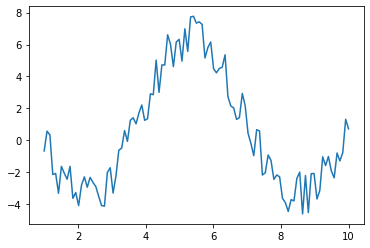

In [3]:
points = np.linspace(1,10,len(data[0]))
sns.lineplot(x=points, y=data[0])

In [4]:
len(data[1])

109

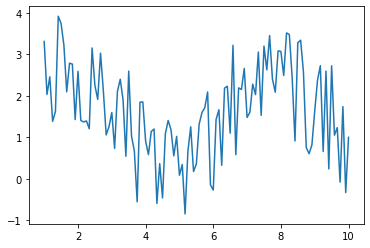

In [5]:
points = np.linspace(1,10,len(data[1]))
sns.lineplot(x=points, y=data[1])

- le nombre de points varie légerement entre les séries, et donc le temps d'acquisition de chaque valeur de la série temporelle comme la frequence d'échantillonage reste constante

### Interpolation linéaire

on veut ramener tous les échantillon à 100 points, comme c'est le nombre de point de la plus petite TS du jeu de donnée

In [9]:
interpolation_times =  np.linspace(1,10,100) # les points du temps ou l'on veut interpoler

interpolated_data = list()
for ts in data:
    original_ts_time = np.linspace(1,10,len(ts))
    interpolation_function = scipy.interpolate.interp1d(original_ts_time, ts) # genere la fonction d'interpolation
    interpolated_values = interpolation_function(interpolation_times) # obtient les valeurs aux instants que l'on souhaite
    interpolated_data.append(interpolated_values)

In [10]:
len(interpolated_data)

1000

In [11]:
len(interpolated_data[1])

100

- on s'est bien ramené à un jeu de donnée "homogene", constitué de series temporelles
    - ayant un meme nombre de point
    - interpolées au mêmes instants (ceux d'interpolation_times)

In [12]:
train_and_eval(interpolated_data, labels)

	Precision: 0.795
	Recall: 0.937


### Extraction d'indicateurs simples

- creer des features simples : moyenne, std, max, min

In [14]:
sample_mean = np.mean(interpolated_data, axis=1)
sample_std = np.std(interpolated_data, axis=1)
sample_max = np.max(interpolated_data, axis=1)
sample_min = np.min(interpolated_data, axis=1)

In [15]:
featured_data = np.zeros((1000,4))
featured_data[:,0] =sample_mean 
featured_data[:,1] =sample_std 
featured_data[:,2] =sample_max 
featured_data[:,3] =sample_min 

- Verifions l'interet de nos features :

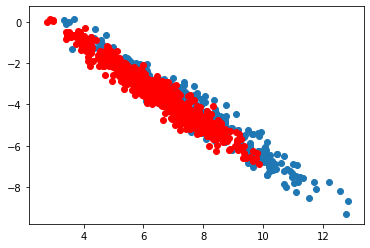

In [20]:
plt.scatter(featured_data[:,2][np.array(labels)==0], featured_data[:,3][np.array(labels)==0])
plt.scatter(featured_data[:,2][np.array(labels)==1], featured_data[:,3][np.array(labels)==1], color='red')
plt.show()

In [21]:
train_and_eval(featured_data, labels)

	Precision: 0.864
	Recall: 0.966


### PCA

In [22]:
from sklearn.decomposition import PCA

pca_data = PCA(n_components=3).fit_transform(interpolated_data)

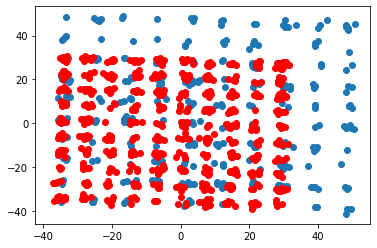

In [23]:
plt.scatter(pca_data[:,0][np.array(labels)==0], pca_data[:,1][np.array(labels)==0])
plt.scatter(pca_data[:,0][np.array(labels)==1], pca_data[:,1][np.array(labels)==1], color='red')
plt.show()

- ça a l'air mieux
- quel drole de motif, un quadrillage de taille 10 alors que j'ai généré les données avec des randints prenant 10 valeurs possibles !

In [24]:
train_and_eval(pca_data, labels)

	Precision: 0.948
	Recall: 0.964


- c'est mieux !

### FFT

In [25]:
from scipy.fft import fft
fft_data = np.array([np.abs(scipy.fft.fft(x))[0:3] for x in interpolated_data])
fft_data = fft_data/np.mean(fft_data)

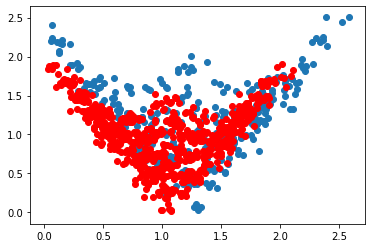

In [26]:
plt.scatter(fft_data[:,0][np.array(labels)==0], fft_data[:,1][np.array(labels)==0])
plt.scatter(fft_data[:,0][np.array(labels)==1], fft_data[:,1][np.array(labels)==1], color='red')
plt.show()

In [27]:
train_and_eval(fft_data, labels)

	Precision: 0.868
	Recall: 0.940


- c'est moins bien !

In [28]:
concat_data = np.concatenate((np.array(fft_data), np.array(pca_data)), axis=1)

In [29]:
train_and_eval(concat_data, labels)

	Precision: 0.934
	Recall: 0.945


- mais cela apporte quand même ajouté à la pca simple !

## Les wavelets

In [31]:
from scipy.signal import cwt
from scipy import signal
widths = np.arange(1,30)
wavelet_data = np.array([np.abs(cwt(x, signal.ricker, widths= np.arange(1,30))) for x in interpolated_data])
wavelet_data = wavelet_data/np.mean(wavelet_data)

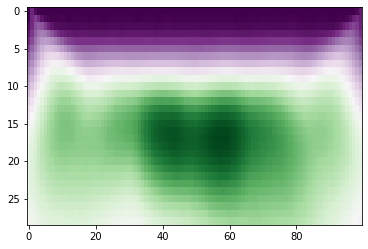

In [32]:
plt.imshow(np.mean(wavelet_data[np.array(labels)==0],axis=0), cmap='PRGn', aspect='auto')

In [33]:
plt.imshow(np.mean(wavelet_data[np.array(labels)==1],axis=0), cmap='PRGn',aspect='auto')

- la difference a l'air plus flagrante "en bas"

In [ ]:
wavelet_data = None
plt.imshow(np.mean(wavelet_data[np.array(labels)==0],axis=0), cmap='PRGn', aspect='auto')

In [ ]:
plt.imshow(np.mean(wavelet_data[np.array(labels)==1],axis=0), cmap='PRGn',aspect='auto')

In [34]:
wavelet_data_max= np.max(wavelet_data, axis=(1,2))
wavelet_data_mean= np.mean(wavelet_data, axis=(1,2))
wavelet_data_std = np.std(wavelet_data, axis=(1,2))
wavelet_data_min = np.min(wavelet_data, axis=(1,2))

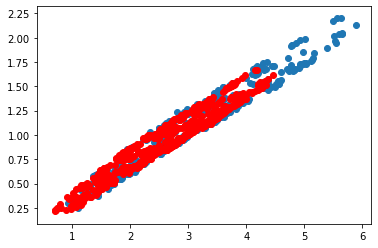

In [35]:
plt.scatter(wavelet_data_max[:][np.array(labels)==0], wavelet_data_mean[:][np.array(labels)==0])
plt.scatter(wavelet_data_max[:][np.array(labels)==1], wavelet_data_mean[:][np.array(labels)==1], color='red')
plt.show()

In [36]:
wave_data = np.zeros((1000,4))
wave_data[:,0] =wavelet_data_max
wave_data[:,1] =wavelet_data_mean
wave_data[:,2] =wavelet_data_min
wave_data[:,3] =wavelet_data_std
train_and_eval(wave_data, labels)

	Precision: 0.797
	Recall: 0.908


- moins interessant que l'approche fft

In [ ]:
pca_wave = None

In [ ]:
train_and_eval(pca_wave, labels)

- un peu mieux avec une pca

In [ ]:
concat_data = None

In [ ]:
train_and_eval(concat_data, labels)

- redondant avec la fft

# Et pour aller plus loin ?:
- creuser davantage les paramètres de chaques methodes et les combinaisons de features
- selection automatique des meilleures features, ... 
- ts_fresh
- changer le modèle
- utilisation de réseaux de neurones (convolution, lstm)